<a href="https://colab.research.google.com/github/KwonHo-geun/AI_Study/blob/main/25.07.11_VGG16_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **AlexNet 구현**

In [1]:
!unzip -qq "/content/CNN 응용.zip"

In [3]:
import kagglehub
import os
# Download latest version
path = kagglehub.dataset_download("ajayrana/hymenoptera-data")

src = path  # kagglehub가 반환한 실제 경로
dst = "/content/hymenoptera-data"
os.symlink(src, dst)
print("심볼릭 링크 생성 완료:", dst)


심볼릭 링크 생성 완료: /content/hymenoptera-data


In [4]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, models, transforms


In [6]:
ddir = '/content/hymenoptera-data/hymenoptera_data/hymenoptera_data'

batch_size = 64
num_workers = 2

data_transformers = {
    'train': transforms.Compose(
        [
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
        ]
    ),
    'val': transforms.Compose(
        [
         transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.490, 0.449, 0.411],[0.231, 0.221, 0.230])
        ]
    )
}

img_data = {
    k: datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k])
    for k in ['train', 'val']
}
dloaders = {
    k: torch.utils.data.DataLoader(
        img_data[k], batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    for k in ['train', 'val']
}
dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']}
classes = img_data['train'].classes

dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


VGGNet

In [16]:
import torch
import torch.nn as nn

cfg = {
    'vgg16' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256,      'M', 512, 512, 512,      'M', 512, 512, 512,      'M'],
    'vgg19' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

class VGG(nn.Module):

    def __init__(self, features, num_classes=100):
        super().__init__()
        self.features = features

        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        output = self.features(x)
        output = output.view(output.size()[0], -1)
        output = self.classifier(output)

        return output

def make_layers(cfg):
    layers = []

    input_channel = 3
    for l in cfg:
        if l == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            continue

        layers += [nn.Conv2d(input_channel, l, kernel_size=3, padding=1)]

        #레이어 진행 시 overfitting을 잡게 함
        layers += [nn.BatchNorm2d(l)]

        layers += [nn.ReLU(inplace=True)]
        input_channel = l

    return nn.Sequential(*layers)


def vgg16(num=100):
    return VGG(make_layers(cfg['vgg16']),num_classes=num)

def vgg19(num=100):
    return VGG(make_layers(cfg['vgg19']),num_classes=num)



학습

In [17]:
def train(model, loss_func, optimizer, epochs=10):
   start = time.time()

   accuracy = 0.0

   for e in range(epochs):
        print(f'Epoch number {e}/{epochs - 1}')
        print('=' * 20)

        for dset in ['train', 'val']:
            if dset == 'train':
                model.train()
            else:
                model.eval()

            loss = 0.0
            successes = 0

            for imgs, tgts in dloaders[dset]:
                imgs = imgs.to(dvc)
                tgts = tgts.to(dvc)
                optimizer.zero_grad()

                with torch.set_grad_enabled(dset == 'train'):
                    ops = model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)

                    if dset == 'train':
                        loss_curr.backward()
                        optimizer.step()

                loss += loss_curr.item() * imgs.size(0)
                successes += torch.sum(preds == tgts.data)

            loss_epoch = loss / dset_sizes[dset]
            accuracy_epoch = successes.double() / dset_sizes[dset]

            print(f'{dset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {accuracy_epoch}')
            if dset == 'val' and accuracy_epoch > accuracy:
                accuracy = accuracy_epoch

   time_delta = time.time() - start
   print(f'Training finished in {time_delta // 60}mins {time_delta % 60}secs')
   print(f'Best validation set accuracy: {accuracy}')


   return model


In [18]:
#2 ->image class
model = vgg19(2)
if torch.cuda.is_available():
  model = model.cuda()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [19]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
pretrained_model = train(model, loss_func, optimizer, epochs=5)

Epoch number 0/4
train loss in this epoch: 2.736181567926876, accuracy in this epoch: 0.4139344262295082
val loss in this epoch: 0.6909652632825515, accuracy in this epoch: 0.542483660130719
Epoch number 1/4
train loss in this epoch: 1.0146697212438114, accuracy in this epoch: 0.49180327868852464
val loss in this epoch: 0.6917844551061493, accuracy in this epoch: 0.542483660130719
Epoch number 2/4
train loss in this epoch: 0.7462376395209891, accuracy in this epoch: 0.5450819672131147
val loss in this epoch: 0.7554117195746478, accuracy in this epoch: 0.4575163398692811
Epoch number 3/4
train loss in this epoch: 0.719584695628432, accuracy in this epoch: 0.5122950819672132
val loss in this epoch: 0.7033500714239731, accuracy in this epoch: 0.4575163398692811
Epoch number 4/4
train loss in this epoch: 0.7061653332632096, accuracy in this epoch: 0.5860655737704918
val loss in this epoch: 0.7006174446710574, accuracy in this epoch: 0.4575163398692811
Training finished in 0.0mins 41.594742

In [20]:
def test(model=pretrained_model):

  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}


  with torch.no_grad():
      for images, labels in dloaders['val']:


          images = images.to(dvc)
          labels = labels.to(dvc)

          outputs = model(images)
          _, predictions = torch.max(outputs, 1)

          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1



  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [21]:
test(pretrained_model)

Accuracy for class: ants  is 100.0 %
Accuracy for class: bees  is 0.0 %


이미지확인

In [22]:
def imageshow(img, text=None):
  img = img.numpy().transpose((1,2,0))
  avg = np.array([0.490, 0.449, 0.411])
  stddev = np.array([0.231, 0.221, 0.230])
  img = stddev * img + avg
  img = np.clip(img, 0, 1)
  plt.imshow(img)
  if text is not None:
    plt.title(text)

In [23]:
def visualize_predictions(pretrained_model, max_num_imgs=4):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            imgs = imgs.to(dvc)
            tgts = tgts.to(dvc)
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)

            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')
                ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[tgts[j]]}')
                imageshow(imgs.cpu().data[j])

                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

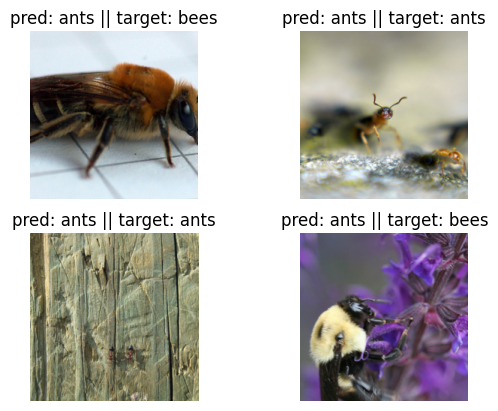

In [24]:
visualize_predictions(pretrained_model)